In [1]:
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import iris.quickplot as qplt
import netCDF4
import datetime
import scipy
import scipy.signal
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import t

"""
Potential issues to think about:
    William uses: Might only SST values (because from satilite). Models are at best deaily mean
    They use a standardising year of 1988.3 which would not necessarily be a sensble year to use given model metholology
    


Skirving methodology
Regarding the current methodology for deriving the MMM it goes like this:



1)  for the period of 1985 to 2012, turn each yearly month into an average SST value (only night-only SST values).
2)  for each month, fit a linear regression to the 28 SST values across all years  ie Y = a + bX, where Y is the monthly averaged SST and X is the year
3)  at this stage you will have 12 linear regressions per pixel, one for each month.  Determine the SST value for X = 1988.3
4)  this will provide you with 12 SST values, the maximum of which will be the MMM value for that pixel, the month that this value represents is called the MMM month.
"""

directory = '/Users/ph290/Downloads/revelle2/'

/Users/ph290/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region

In [3]:
def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN, weights=grid_areas)

In [4]:

def linregress_3D(y_array):
    # y_array is a 3-D array formatted like (time,lon,lat)
    # The purpose of this function is to do linear regression using time series of data over each (lon,lat) grid box with consideration of ignoring np.nan
    # Construct x_array indicating time indexes of y_array, namely the independent variable.
    x_array=np.empty(y_array.shape)
    for i in range(y_array.shape[0]): x_array[i,:,:]=i+1 # This would be fine if time series is not too long. Or we can use i+yr (e.g. 2019).
    x_array[np.isnan(y_array)]=np.nan
    # Compute the number of non-nan over each (lon,lat) grid box.
    n=np.sum(~np.isnan(x_array),axis=0)
    # Compute mean and standard deviation of time series of x_array and y_array over each (lon,lat) grid box.
    x_mean=np.nanmean(x_array,axis=0)
    y_mean=np.nanmean(y_array,axis=0)
    x_std=np.nanstd(x_array,axis=0)
    y_std=np.nanstd(y_array,axis=0)
    # Compute co-variance between time series of x_array and y_array over each (lon,lat) grid box.
    cov=np.nansum((x_array-x_mean)*(y_array-y_mean),axis=0)/n
    # Compute correlation coefficients between time series of x_array and y_array over each (lon,lat) grid box.
    cor=cov/(x_std*y_std)
    # Compute slope between time series of x_array and y_array over each (lon,lat) grid box.
    slope=cov/(x_std**2)
    # Compute intercept between time series of x_array and y_array over each (lon,lat) grid box.
    intercept=y_mean-x_mean*slope
    # Compute tstats, stderr, and p_val between time series of x_array and y_array over each (lon,lat) grid box.
    tstats=cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr=slope/tstats
    p_val=t.sf(tstats,n-2)*2
    # Compute r_square and rmse between time series of x_array and y_array over each (lon,lat) grid box.
    # r_square also equals to cor**2 in 1-variable lineare regression analysis, which can be used for checking.
    r_square=np.nansum((slope*x_array+intercept-y_mean)**2,axis=0)/np.nansum((y_array-y_mean)**2,axis=0)
    rmse=np.sqrt(np.nansum((y_array-slope*x_array-intercept)**2,axis=0)/n)
    # Do further filteration if needed (e.g. We stipulate at least 3 data records are needed to do regression analysis) and return values
    n=n*1.0 # convert n from integer to float to enable later use of np.nan
    n[n<3]=np.nan
    slope[np.isnan(n)]=np.nan
    intercept[np.isnan(n)]=np.nan
    p_val[np.isnan(n)]=np.nan
    r_square[np.isnan(n)]=np.nan
    rmse[np.isnan(n)]=np.nan
#     return n,slope,intercept,p_val,r_square,rmse
    return slope,intercept

In [5]:
# https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/joc.3486
# the monthly data set for 1982 – 2006 was first detrended using a linear regression, calculated for each month of the year and grid cell. The data set was detrended and centred on 1988
# I don't like this - it becoes ver deending on whether 1988 is a warm or cold year/...

def mmm_for_dhm(cube):
    years_for_mmm_climatology = [1985,2000]
    #####################################################
    #Avreage months separately!!!!!!!!!!!
#####################################################
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    #collapse the months together, taking the maximum value at each lat-lon grid square
    mmm_climatology = clim_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology

def mmm_skirving(cube):
    #_for_dhw
    missing_data_value = cube.data.fill_value
    print 'NOTE THIS SHOULD IDEALLY BE USING AN AVERAGE OF NIGHTIME TEMPERATURES, WHICH IS NOT A BED ESTIMATE FOR DAILY MEAN. A GOOD ALTERNATIEV FOR DAILY MEAN IS 10am (whet chris merchant does)'
    years_for_mmm_climatology = [1985,2012]
    standardisation_date = 1988.2857
    mm_cube = cube[0:12].copy()
    mm_cube_data = mm_cube.data.copy()
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    clim_cube_detrended = clim_cube.copy()
    clim_cube_detrended_data = clim_cube_detrended.data
    print np.shape(clim_cube_detrended)
    for i,month in enumerate(np.unique(cube.coord('month_number').points)):
        loc = np.where(clim_cube.coord('month_number').points == month)
        tmp = clim_cube_detrended_data[loc,:,:][0]
        tmp[np.where(tmp == missing_data_value)] = np.nan
        slope,intercept = linregress_3D(tmp)
        x = standardisation_date - years_for_mmm_climatology[0]
        y = (slope * x ) + intercept
        mm_cube_data[i,:,:] = y
    mm_cube.data = mm_cube_data
    mmm_climatology = mm_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology

In [6]:
def dhw(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    cube_years = cube.coord('year').points
    #note this is to be uef with daily data...
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data

    #set all values less than 1 to zero
    main_cube.data[np.where(main_cube.data < 1.0)] = 0.0 

    #make a cube to hold the output data
    output_cube = main_cube[83::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

    #loop through from day 84 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        #sum the temperatures in that 84 day window and divide result by 7 to get in DHWeeks rather than DHdays
        tmp_data = main_cube[i:i+84].collapsed('time',iris.analysis.SUM)/7.0
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

In [7]:


def dhm(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    #This hsould be given monthly data
    # One DHM == 4DHW This is important
#     mmm is straight averg not fdetreneded for DHM
    #Look at the donna poapers - look over two papers...
    #accumulation window is 4 months rather than 3 months.
    cube_years = cube.coord('year').points
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology # at this stage this is called a hot spot (which is anything greater than the mmm)

    #set all values less than 1 to zero
#     main_cube.data[np.where(main_cube.data <= 1.0)] = 0.0
    #OR
    main_cube.data[np.where(main_cube.data < 0.0)] = 0.0

    #make a cube to hold the output data
    output_cube = main_cube[3::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

        #AVEREG OVER A 4 month  window rather than 3 month when it comes to DHW


    #loop through from day 112 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        tmp_data = main_cube[i:i+4].collapsed('time',iris.analysis.SUM)
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

In [8]:
def merge_two_cubes(cubes):
    data1 = cubes[0].data
    data2 = cubes[1].data
    data = np.concatenate([data1,data2],axis=0)
    data = np.ma.masked_where(data == cubes[0].data.fill_value, data)

    length = cubes[0].shape[0] + cubes[1].shape[0]
    datetime_object1 = netCDF4.num2date(cubes[0].coord('time').points,cubes[0].coord('time').units.name,cubes[0].coord('time').units.calendar)
    datetime_object2 = netCDF4.num2date(cubes[1].coord('time').points,cubes[1].coord('time').units.name,cubes[1].coord('time').units.calendar)
    datetime_object = np.concatenate([datetime_object1,datetime_object2])
    try:
        tmp =  [x._to_real_datetime() - datetime.datetime(1850,1,1) for x in datetime_object]
    except:
        tmp =  [x - datetime.datetime(1850,1,1) for x in datetime_object]
    days_since_18500101 = [x.days for x in tmp]

    time = iris.coords.DimCoord(days_since_18500101, standard_name='time',long_name=u'time', var_name='time', units='days since 1850-1-1')
    latitude = iris.coords.DimCoord(range(-90, 90, 1), standard_name='latitude', units='degrees')
    longitude = iris.coords.DimCoord(range(0, 360, 1), standard_name='longitude', units='degrees')
    cube = iris.cube.Cube(data,standard_name='sea_surface_temperature',long_name='Sea Surface Temperature', var_name='tos', units='K',dim_coords_and_dims=[(time,0), (latitude, 1),
    (longitude, 2)])
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
    return cube

set up the dictonary with model names

In [9]:
models = ['BCC-CSM2-MR','CanESM5','MPI-ESM1-2-HR','CESM2','MIROC6','MRI-ESM2-0']

colors = ['r','g','b','k','m','c']
model_dict = {}
for i,model in enumerate(models):
    model_dict[model] = {}
    model_dict[model]['color'] = colors[i]


# BCC-CSM2-MR_tos_historical_r1i1p1f1_gn.nc	BCC-CSM2-MR_tos_ssp585_r1i1p1f1_gn.nc

read in the model data

In [10]:
cube_dict = {}

for model in models:
    cube_dict[model] = {}
    # file = glob.glob(model+'_tos_*_r1i1p1f1_gn.nc')
    # print file

    cubes = iris.load(directory+model+'_tos_*_r1i1p1f1_gn.nc')
    # cubes2 = iris.load(model+'_tos_ssp585_r1i1p1f1_gn.nc')
    # cubes = iris.cube.CubeList([cubes1,cubes2])

    cube =  merge_two_cubes(cubes)
    cube_dict[model]['cube'] = cube




/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'tos'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


testing with 3hourly sst to compare day and night

In [11]:
file = '/data/BatCaveNAS/ph290/cmip6/tmp2/processed/tos_3hr_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_regridded.nc'
cube = iris.load_cube(file)

IOError: One or more of the files specified did not exist ['/data/BatCaveNAS/ph290/cmip6/tmp2/processed/tos_3hr_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_regridded.nc expanded to empty'].

calculate dhws

In [104]:
for model in models:
    print model
    years_over_which_to_calculate_dhw = [2012,2100]
    mmm_climatology = mmm_skirving(cube_dict[model]['cube'],years_for_mmm_climatology)
    dhm_cube = dhm(cube_dict[model]['cube'],mmm_climatology,years_over_which_to_calculate_dhw)
    dhm_cube_Spillman_2013 = dhm_Spillman_2013(cube_dict[model]['cube'],mmm_climatology,years_over_which_to_calculate_dhw)
    lon_west = 142.0
    lon_east = 157.0
    lat_south = -30.0
    lat_north = -10.0
    dhm_cube_gbr = extract_region(dhm_cube,lon_west,lon_east,lat_south,lat_north)
    cube_dict[model]['dhm'] = dhm_cube_gbr
    cube_dict[model]['dhm_cube_Spillman_2013'] = dhm_cube_Spillman_2013
    

BCC-CSM2-MR
NOTE THIS SHOULD BE USING NIGHT TIME TEMPERATURES
(336, 180, 360)


/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in divide


CanESM5
NOTE THIS SHOULD BE USING NIGHT TIME TEMPERATURES
(336, 180, 360)
MPI-ESM1-2-HR
NOTE THIS SHOULD BE USING NIGHT TIME TEMPERATURES
(336, 180, 360)


/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide


CESM2
NOTE THIS SHOULD BE USING NIGHT TIME TEMPERATURES
(336, 180, 360)
MIROC6
NOTE THIS SHOULD BE USING NIGHT TIME TEMPERATURES
(336, 180, 360)
MRI-ESM2-0
NOTE THIS SHOULD BE USING NIGHT TIME TEMPERATURES
(336, 180, 360)


In [105]:
def asb(cube,threshold):
    dhm_cube_gbr_tmp = cube.copy()
    dhm_cube_gbr_tmp_data = dhm_cube_gbr_tmp.data
    dhm_cube_gbr_tmp_data[np.where(dhm_cube_gbr_tmp_data <= threshold)] = 0.0
    dhm_cube_gbr_tmp_data[np.where(dhm_cube_gbr_tmp_data > threshold)] = 1.0
    dhm_cube_gbr_tmp.data = dhm_cube_gbr_tmp_data
    dhm_cube_gbr_asb = dhm_cube_gbr.copy()
    dhm_cube_gbr_asb = dhm_cube_gbr_tmp.aggregated_by(['year'], iris.analysis.SUM)
    dhm_cube_gbr_asb_tmp = dhm_cube_gbr_asb.data
    dhm_cube_gbr_asb_tmp[np.where(dhm_cube_gbr_asb_tmp > 1.0)] = 1.0
    dhm_cube_gbr_asb.data = dhm_cube_gbr_asb_tmp
    return dhm_cube_gbr_asb
    
for model in models:
    dhm_cube_gbr = extract_region(cube_dict[model]['dhm'],lon_west,lon_east,lat_south,lat_north)
    dhm_cube_gbr_Spillman_2013 = extract_region(cube_dict[model]['dhm_cube_Spillman_2013'],lon_west,lon_east,lat_south,lat_north)
    dhm_cube_gbr_tmp = dhm_cube_gbr_Spillman_2013.copy()
    dhm_cube_gbr_asb = asb(dhm_cube_gbr,2.0)
    dhm_cube_gbr_asb_area_avg = area_avg(dhm_cube_gbr_asb)
    cube_dict[model]['asb'] = dhm_cube_gbr_asb
    cube_dict[model]['asb_avg'] = dhm_cube_gbr_asb_area_avg
    cube_dict[model]['dhm_avg_avg'] = area_avg(dhm_cube_gbr.aggregated_by(['year'], iris.analysis.MEAN))
    cube_dict[model]['dhm_cube_Spillman_2013_avg'] = area_avg(dhm_cube_gbr_Spillman_2013.aggregated_by(['year'], iris.analysis.MEAN))

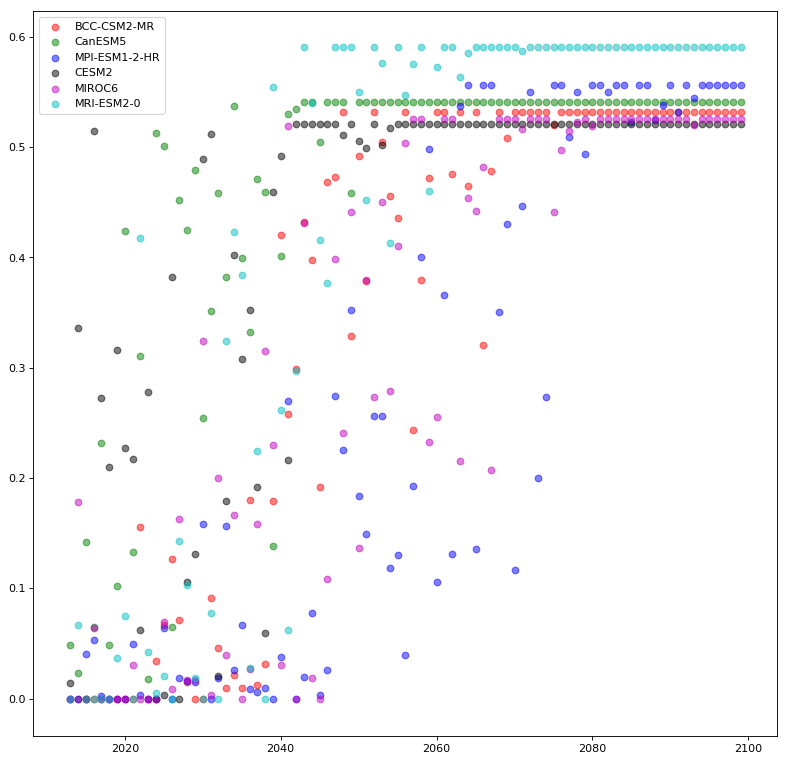

In [110]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')


for model in models:
#     print cube_dict[model]['asb'].coord('year').points
#     y = cube_dict[model]['asb_avg'].data
#     y[np.where(y > 0.0)] = 1
    plt.scatter(cube_dict[model]['asb'].coord('year').points,cube_dict[model]['asb_avg'].data,alpha=0.5,color=model_dict[model]['color'],label = model)

# plt.ylim([-0.1,1.1])
plt.legend()
plt.show()

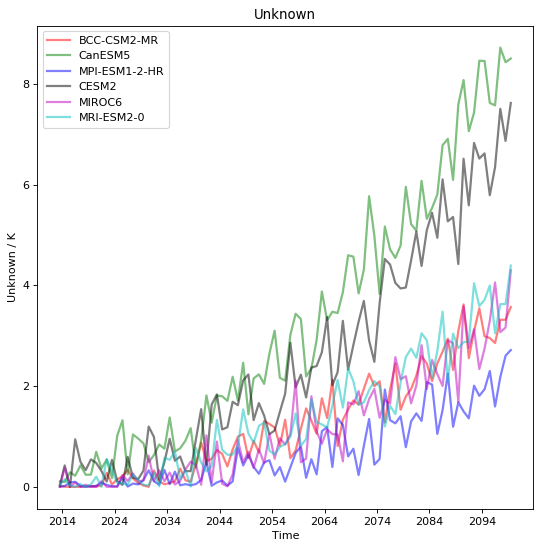

In [108]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# for model in models:
#     qplt.plot(cube_dict[model]['dhm_cube_Spillman_2013_avg'],lw = 2,alpha=0.5,color=model_dict[model]['color'])

    
for model in models:
    qplt.plot(cube_dict[model]['dhm_avg_avg'],lw=2,color=model_dict[model]['color'],label = model,alpha=0.5)


# plt.ylim([0,0.5])
plt.legend()

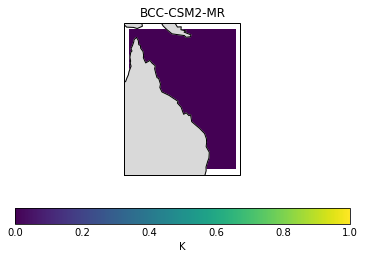

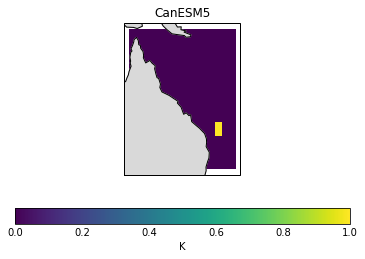

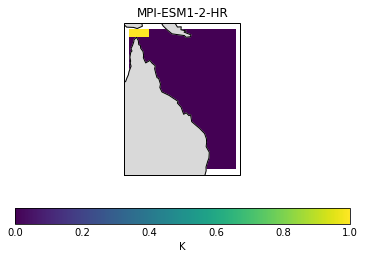

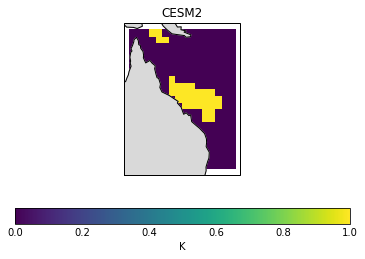

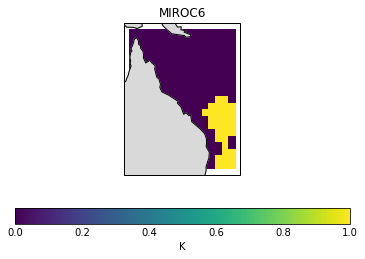

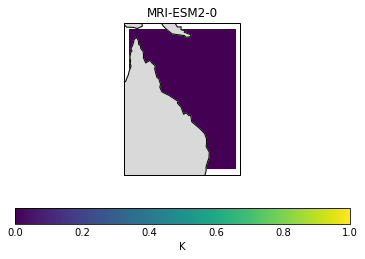

In [103]:

land_110m = cfeature.NaturalEarthFeature('physical', 'land', '110m',edgecolor='face',facecolor=(0.85, 0.85, 0.85))

for i,model in enumerate(models):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    qplt.pcolormesh(cube_dict[model]['asb'][0:20].collapsed('time',iris.analysis.MAX),vmin=0,vmax=1)
    ax.add_feature(land_110m)
    plt.gca().coastlines()
    plt.title(model)
    qplt.show()